In [1]:
import os
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    EnsureChannelFirstd,
    RandFlipd,
    RandRotated,
    ToTensord,
    Resized,
    RandSpatialCropSamplesd,
    RandRotate90d,
    RandShiftIntensityd,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd
)
from monai.transforms.transform import MapTransform
from monai.transforms.inverse import InvertibleTransform

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

In [2]:
class RemoveDicts(MapTransform, InvertibleTransform):

    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            self.push_transform(d, key)
        # print(d["image_meta_dict"]["filename_or_obj"])
        a = {"image": d["image"], "label": d["label"], "path": d["image_meta_dict"]["filename_or_obj"]}
        # print(a["path"])
        d = a
        return d

    def inverse(self, data: Mapping[Hashable, Any]) -> Dict[Hashable, Any]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            d[key] = d[key]
            # Remove the applied transform
            self.pop_transform(d, key)
        return d


In [3]:
from monai.visualize import matshow3d, blend_images
import imageio
def make_gif(predictions):
    volumes = []
    for prediction in predictions:
        selected = prediction

        pred = torch.argmax(selected['output'], dim=1).detach().cpu().numpy()
        true_label = torch.sum(selected['label'][:,1:,:,:,:], dim=1).detach().cpu().numpy()
        image = selected['image'][0].cpu().numpy()

        blended_true_label = blend_images(image, true_label)
        blended_final_true_label = torch.from_numpy(blended_true_label).permute(1,2,0,3)

        blended_prediction = blend_images(image, pred)
        blended_final_prediction = torch.from_numpy(blended_prediction).permute(1,2,0,3)

        volume_pred = blended_final_prediction[:,:,:,:]
        volume_label = blended_final_true_label[:,:,:,:]
        volume_pred = np.squeeze(volume_pred).permute(3,0,1,2)
        volume_label = np.squeeze(volume_label).permute(3,0,1,2)
        volume = torch.hstack((volume_pred, volume_label)).numpy()
        volumes.append(volume)
    volume = np.hstack((volumes))
    data = volume.astype(np.float64) / np.max(volume) # normalize the data to 0 - 1
    data = 255 * data # Now scale by 255
    volume = data.astype(np.uint8)
    path_to_gif = f'gifs\\prediction.gif'
    if not os.path.exists("gifs\\"):
        os.mkdir("gifs\\")
    imageio.mimsave(path_to_gif, volume)
    return path_to_gif

In [44]:
import SimpleITK as sitk

super_amazing_case = os.path.join("/mnt/chansey", "lauraalvarez", "data", "liver", "train", "scans", "L110147.mha")
super_amazing_case_label = os.path.join("/mnt/chansey", "lauraalvarez", "data", "liver", "train", "overlays", "L110147.mha")


img = sitk.ReadImage(super_amazing_case)
lab = sitk.GetArrayFromImage(sitk.ReadImage(super_amazing_case_label))

print(np.unique(lab))




Uncompress failed


[0]


In [45]:
lab.shape

(6, 2976, 512, 512)

In [4]:
import matplotlib.pyplot as plt
from ipywidgets.widgets import * 
import ipywidgets as widgets
import matplotlib.pyplot as plt

no_injure_liver = os.path.join("/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "imagesTr", "TRMLIV_073_0000.nii.gz")
# label_error = os.path.join( "U:", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "TRMLIV_073_0000_label_error_maybe.nii.gz")
# scan_error = os.path.join( "U:", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "TRMLIV_073_0000_scan_error_maybe.nii.gz")
no_injure_liver_label = os.path.join(  "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "labelsTr", "TRMLIV_073_0000.nii.gz")
injure_liver = os.path.join(  "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "imagesTr", "TRMLIV_046_0000.nii.gz")
injure_liver_label = os.path.join( "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "labelsTr", "TRMLIV_046_0000.nii.gz")

In [50]:
import nibabel as nib
img = injure_liver
label = injure_liver_label

img_ni = nib.load(img)
img_ni_label = nib.load(label)

# img_in = nib.load(injure_liver)
# img_in_label = nib.load(injure_liver_label)

ni_arr = img_ni.get_fdata()
# in_arr = img_in.get_fdata()
ni_arr_label = img_ni_label.get_fdata()
# in_arr_label = img_in_label.get_fdata()

KeyboardInterrupt: 

In [7]:
import numpy as np
np.expand_dims(ni_arr_label, axis=0).shape

(1, 512, 512, 2976)

In [14]:
injures = {'image': ni_arr, 'label':ni_arr_label}
train_transforms = Compose(
            [
                AddChanneld(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                # Resized(keys=["image", "label"], spatial_size=self.val_img_size),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )
injures = train_transforms(injures)


NameError: name 'ni_arr' is not defined

In [5]:
paths = {'image': injure_liver, 'label': injure_liver_label}
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                RemoveDicts(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                # Resized(keys=["image", "label"], spatial_size=self.val_img_size),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
                # RemoveDicts(keys=["image", "label"]),
            ]
        )
injures = val_transforms(paths)

In [16]:
injures["image"].shape

torch.Size([1, 342, 263, 633])

In [17]:
injures["label"]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [6]:
import numpy as np
np.unique(injures["label"])

array([0., 1., 2.], dtype=float32)

In [11]:
from monai.visualize import matshow3d, blend_images
import torch 

# blended_label_ni = blend_images(np.expand_dims(ni_arr, axis=0), np.expand_dims(ni_arr_label, axis=0) )
# print(blended_label_ni.shape)
# blended_final_label = torch.from_numpy(blended_label_ni).permute(1,2,0,3)

blended_label_in = blend_images(injures["image"].cpu().numpy(), injures["label"].cpu().numpy())
print(blended_label_in.shape)
blended_final = torch.from_numpy(blended_label_in).permute(1,2,0,3)


(3, 339, 260, 681)


In [56]:
blended_final_p = blended_final.T.permute(2,0,1,3)
blended_final.T.permute(1,3,2,0).shape

torch.Size([3, 342, 281, 681])

In [12]:
def dicom_animation(slice):
    # extent = np.min(x), np.max(x), np.min(y), np.max(y)
    plt.figure(figsize=(18, 6))
    plt.title(f"liver no injured ")
    plt.imshow(blended_final[:, :, :, slice], cmap="bone")
    # plt.imshow(ni_arr_label[:, :, :, slice], cmap=plt.cm.viridis, alpha=.15, interpolation=None)
    plt.show()

interact(dicom_animation, slice=(0, blended_final.shape[-1]-1))

interactive(children=(IntSlider(value=340, description='slice', max=680), Output()), _dom_classes=('widget-int…

<function __main__.dicom_animation(slice)>

In [ ]:
def dicom_animation(slice):
    # extent = np.min(x), np.max(x), np.min(y), np.max(y)
    plt.figure(figsize=(18, 6))
    plt.title(f"liver no injured ")
    plt.imshow(in_arr[:, :, slice], cmap="bone")
    plt.imshow(in_arr_label[:, :, slice], cmap=plt.cm.viridis, alpha=.15, interpolation=None)
    plt.show()

interact(dicom_animation, slice=(0, in_arr_label.shape[-1]-1))

interactive(children=(IntSlider(value=704, description='slice', max=1408), Output()), _dom_classes=('widget-in…

<function __main__.dicom_animation(slice)>

In [32]:
pip install nilearn

     |████████████████████████████████| 9.6 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 103.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


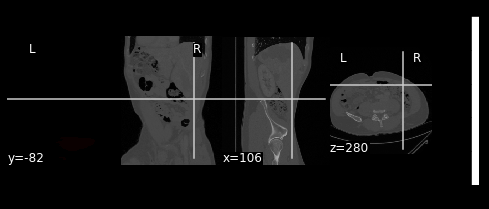

In [33]:
from nilearn import plotting
display = plotting.plot_anat(injure_liver)  # plot volume 
display.add_overlay(injure_liver_label,cmap='hot', colorbar=True) 

In [97]:
import numpy as np
from monai.data.image_reader import ImageReader, ITKReader
from ipywidgets.widgets import *
import ipywidgets as widgets

import matplotlib.pyplot as plt
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    EnsureChannelFirstd,
    RandFlipd,
    RandRotated
)
import wandb
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss, GeneralizedDiceLoss
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import os
import glob
from tqdm import tqdm
import numpy as np
from monai.data import DataLoader
import os
import glob
from monai.transforms.spatial.array import Resize

from copy import deepcopy
from enum import Enum
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.networks.layers import AffineTransform
from monai.networks.layers.simplelayers import GaussianFilter
from monai.transforms.croppad.array import CenterSpatialCrop, SpatialPad
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.spatial.array import (
    Resize,
)
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.transforms.utils import create_grid
from monai.utils import (
    InterpolateMode,
    ensure_tuple_rep,
)
from monai.utils.deprecate_utils import deprecated_arg
from monai.utils.enums import TraceKeys
from monai.utils.module import optional_import
from monai.utils.type_conversion import convert_data_type, convert_to_dst_type
from monai.apps import load_from_mmar
from monai.apps.mmars import RemoteMMARKeys
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups
import torch.optim as optim
print_config()

MONAI version: 0.8.1
Numpy version: 1.21.5
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [19]:
import numpy as np
test = np.random.randint(low=0, high=2, size=(20))

pred = np.random.uniform(0,1, size=(20))

In [51]:
import torch
from torch import tensor
test = [0, 0, 0, 0, 1, 1, 1, 0,0, 0,]
pred = [tensor(1), tensor(0.5), tensor(0.1), tensor(0.2), tensor(1), 0.15, 0.4, 0.7,0.9, 0.3]

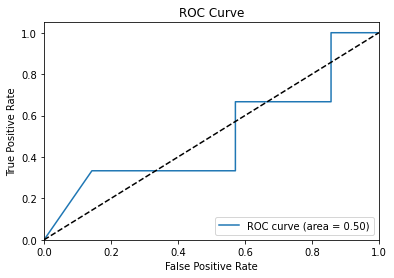

In [52]:
fpr, tpr, _ = roc_curve(test, pred)
roc_auc = auc(fpr,tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc="lower right")
plt.show()

1.0


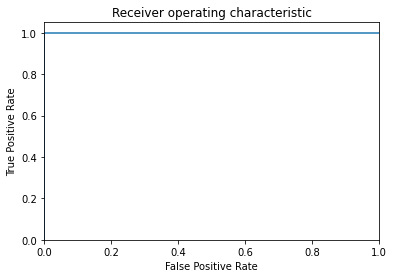

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[0], tpr[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()